In [152]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import *

from sklearn.linear_model import ElasticNet, ElasticNetCV, ModifiedHuber, LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
dat = pd.read_csv('../data/target_concentration_data.csv')
coords = pd.read_csv('../data/kinotype_coords.tsv', sep='\t', index_col=0)
display(X.head())
display(coords.head())

,Drug,Concentration,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,abemaciclib,0.010,NaN,-0.204882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abemaciclib,0.100,NaN,-0.390699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abemaciclib,1.000,NaN,-1.489340,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abemaciclib,0.003,NaN,-0.086717,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abemaciclib,0.030,NaN,-0.265219,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,x,y,Drug,Concentration,Growth
0,11.278050,-46.327190,abemaciclib,0.010,NaN
1,14.062244,-42.569890,abemaciclib,0.100,NaN
2,13.910163,-42.719110,abemaciclib,1.000,NaN
3,14.294827,-43.196968,abemaciclib,0.003,NaN
4,14.181707,-42.938690,abemaciclib,0.030,NaN


In [15]:
sup_dat = dat[~ dat.Growth.isna()]

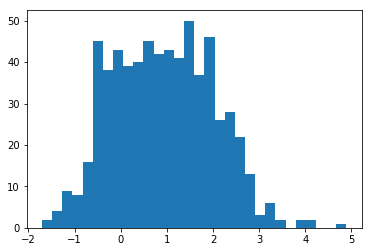

In [40]:
sup_target = sup_dat.Growth.copy()

# truncate the - and + 1 values for arctan transform
# truncate to midway between closest and top
sup_target[sup_target == 1] = np.max(sup_target) * .5 + .5
sup_target[sup_target == -1] = np.min(sup_target) * .5 - .5

sup_target = np.arctanh(sup_dat.Growth)

plt.hist(sup_target, bins=30)
plt.show()

array([0.82111613])

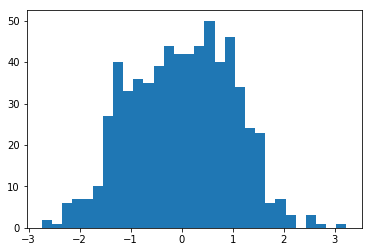

In [43]:
sup_y_transformer = PowerTransformer()
y_sup = sup_y_transformer.fit_transform(np.expand_dims(sup_target.values, 1))

display(sup_y_transformer.lambdas_)

plt.hist(y_sup, bins=30)
plt.show()

In [45]:
groups = sup_dat.Drug.values.copy()
X_sup = sup_dat.iloc[:, 3:]

In [76]:
search_lm = GridSearchCV(LinearRegression(), 
                         n_jobs=2, 
                         param_grid={},
                         pre_dispatch='2*n_jobs', 
                         iid=False, 
                         cv=LeaveOneGroupOut().split(X_sup, groups=groups),
                         refit=False, 
                         return_train_score=True,
                         scoring={'r2':make_scorer(r2_score), 
                                  'mse':make_scorer(mean_squared_error), 
                                   'exp':make_scorer(explained_variance_score)})

In [77]:
search_lm.fit(X_sup, y_sup)

GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7f8e6b1a29a8>,
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid=False, n_jobs=2, param_grid={},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring={'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error), 'exp': make_scorer(explained_variance_score)},
       verbose=0)

In [95]:
search_lm_df = pd.DataFrame(search_lm.cv_results_)
display('Median MSE:', np.round(np.median(search_lm_df[[c for c in search_lm_df.columns if 'mse' in c and 'test' in c]]), 5))
display('Median R2:', np.round(np.median(search_lm_df[[c for c in search_lm_df.columns if 'r2' in c and 'test' in c]]), 5))
display('Median Expl Var:', np.round(np.median(search_lm_df[[c for c in search_lm_df.columns if 'exp' in c and 'test' in c]]), 5))

'Median MSE:'

4.28765

'Median R2:'

-5.32418

'Median Expl Var:'

-2.51298

In [111]:
search_elastic = ElasticNetCV(n_alphas=100, n_jobs=6, l1_ratio=[0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.], cv=LeaveOneGroupOut().split(X_sup, groups=groups))

In [113]:
# this will take a few minutes (up to say 10 on 6 cores)
# search_elastic.fit(X_sup, y_sup);

In [116]:
display(search_elastic.alpha_)
display(search_elastic.l1_ratio_)
display(search_elastic.n_iter_)
display(search_elastic.score(X_sup, y_sup))

0.8094245157293649

0.01

47

0.5009768870389988

In [148]:
e = ElasticNet()
e.alpha = search_elastic.alpha_
e.l1_ratio = search_elastic.l1_ratio_
e.coef = search_elastic.coef_

In [151]:
np.mean(cross_val_score(e, X_sup, y_sup, cv=LeaveOneGroupOut().split(X_sup, groups=groups), scoring=make_scorer(mean_squared_error), n_jobs=2))

0.6570331011270171

In [123]:
search_rf= GridSearchCV(RandomForestRegressor(), 
                         n_jobs=6, 
                         param_grid={'n_estimators':[10,30,100], 
                                     'max_depth':[3,4,5,6]},
                         pre_dispatch='2*n_jobs', 
                         iid=False, 
                         cv=LeaveOneGroupOut().split(X_sup, groups=groups),
                         refit='mse', 
                         return_train_score=True,
                         scoring={'r2':make_scorer(r2_score), 
                                  'mse':make_scorer(mean_squared_error), 
                                   'exp':make_scorer(explained_variance_score)})

In [124]:
search_rf.fit(X_sup, y_sup)

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7f8e6c0c8a98>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=6,
       param_grid={'n_estimators': [10, 30, 100], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit='mse', return_train_score=True,
       scoring={'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error), 'exp': make_scorer(explained_variance_score)},
       verbose=0)

In [129]:
best_rf = search_rf.best_estimator_

In [136]:
np.mean(cross_val_score(best_rf, X_sup, y_sup, cv=LeaveOneGroupOut().split(X_sup, groups=groups), scoring=make_scorer(mean_squared_error), n_jobs=2))

0.7427102455690282

In [177]:
search_gp = GridSearchCV(GaussianProcessRegressor(), 
                         n_jobs=6, 
                         param_grid={'kernel':[Matern(nu=0.5),
                                               Matern(nu=1.5),
                                               Matern(nu=2.5),
                                               RBF()]},
                         pre_dispatch='2*n_jobs', 
                         iid=False, 
                         cv=LeaveOneGroupOut().split(X_sup, groups=groups),
                         refit='mse', 
                         return_train_score=True,
                         scoring={'r2':make_scorer(r2_score), 
                                  'mse':make_scorer(mean_squared_error), 
                                   'exp':make_scorer(explained_variance_score)})

In [178]:
search_gp.fit(X_sup, y_sup);

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/j

In [179]:
gp = search_gp.best_estimator_

In [180]:
np.mean(cross_val_score(gp, X_sup, y_sup, cv=LeaveOneGroupOut().split(X_sup, groups=groups), scoring=make_scorer(mean_squared_error), n_jobs=4))

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/externals/j

1.0014513766584017

In [190]:
semi_labels = pd.Series([d if not np.isnan(g) else 'Unlabeled' for d,g in zip(dat.Drug,dat.Growth)], index=dat.index)
len(semi_labels.unique())

83

In [197]:
from sklearn.semi_supervised import LabelPropagation

In [192]:
search_svr = GridSearchCV(SVR(), 
                         n_jobs=6, 
                         param_grid={'kernel':['linear', 'rbf', 'sigmoid'],
                                    'C':[.1, .2, 1., 2., 10.]},
                         pre_dispatch='2*n_jobs', 
                         iid=False, 
                         cv=LeaveOneGroupOut().split(X_sup, groups=groups),
                         refit='mse', 
                         return_train_score=True,
                         scoring={'r2':make_scorer(r2_score), 
                                  'mse':make_scorer(mean_squared_error), 
                                   'exp':make_scorer(explained_variance_score)})

In [194]:
search_svr.fit(X_sup, y_sup);

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [199]:
svr = search_svr.best_estimator_
svr

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='sigmoid', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [201]:
np.median(cross_val_score(svr, X_sup, y_sup, cv=LeaveOneGroupOut().split(X_sup, groups=groups), scoring=make_scorer(mean_squared_error), n_jobs=4))

20.401913995159475

In [210]:
search_lp = GridSearchCV(LabelPropagation(), 
                         n_jobs=6, 
                         param_grid={'kernel':['knn', 'rbf'],
                                    'n_neighbors':[7,15]},
                         pre_dispatch='2*n_jobs', 
                         iid=False, 
                         cv=LeaveOneGroupOut().split(X_sup, groups=groups),
                         refit='mse', 
                         return_train_score=True,
                         scoring={'r2':make_scorer(r2_score), 
                                  'mse':make_scorer(mean_squared_error), 
                                   'exp':make_scorer(explained_variance_score)})

In [212]:
from pomegranate import NaiveBayes, NormalDistribution

/Users/isrobson/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [237]:
y_semi = np.expand_dims(np.array([g if not np.isnan(g) else None for g in dat.Growth]), 1)

In [224]:
X_semi = dat.iloc[:, 3:].values

In [219]:
from tools.coreg import Coreg

In [238]:
mod_coreg = Coreg()
mod_coreg.X = X_semi
mod_coreg.y = y_semi

In [239]:
mod_coreg.run_trials(trials=3)

Starting trial 1:


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [235]:
display(mod_coreg.mse_test)
display(mod_coreg.mse2_test)
display(mod_coreg.mse1_test)

0.7612715430491664

0.7683456917671967

0.8226162951172725